#Paquetes necesarios

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

Carga imagen y convierte a RGB

(515, 612, 3)


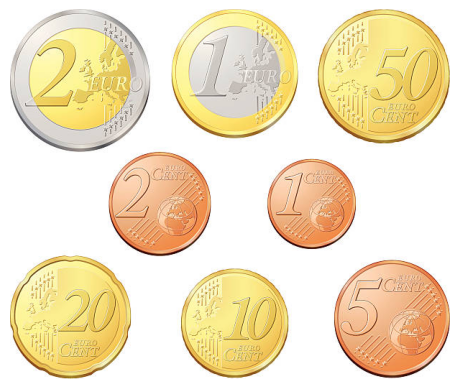

In [3]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

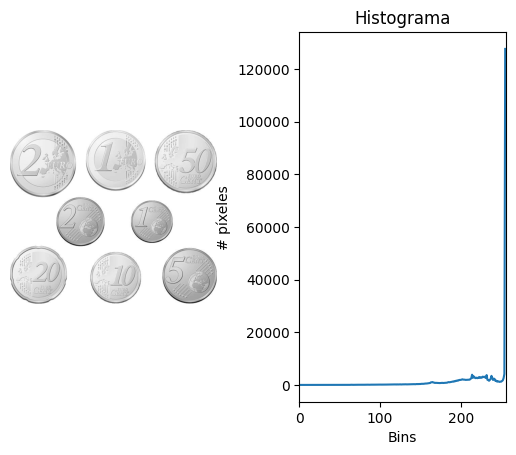

In [4]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])
# Separo subplots horizontalmente
plt.subplots_adjust(wspace=0.4)

Cuenta elementos tras umbralizar

Umbral fijo usado  200.0
Umbral Otsu  206.0


Text(0.5, 1.0, 'OTSU invertida')

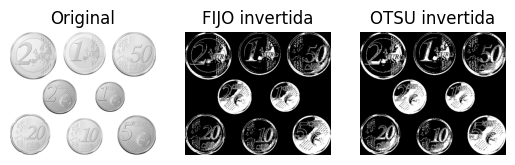

In [5]:
#Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
umbral = 200 # Prueba varios comenzando en 130
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th1)
# Umbralizado con método de Otsu para selección automática del umbral
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral Otsu ', th2)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


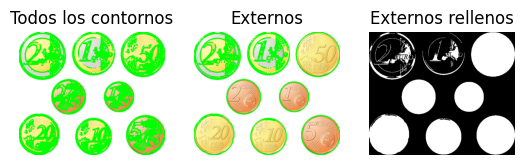

In [6]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con  figura en blanco y fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales (contornos contenidos en otros)

#Obtiene todos los contornos: externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )

#Dibuja sobre la imagen de entrada los contornos en verde
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

#Dibuja contornos externos rellenos en imagen vacía
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno, exgigiendo un mínimo de puntos del contornos
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos puede interesará mostrar los valores obtenidos del contorno
            #print(area, perimetro, rect, cx,cy,radio, elipse)

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()


Alternativa contando círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


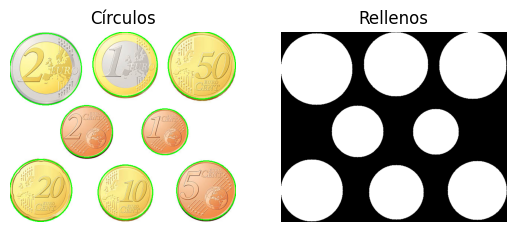

In [7]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=120, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Dibuja sobre entrada e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la corespondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



In [8]:


# 1. Cargar la imagen de las monedas
img = cv2.imread('Monedas.jpg')
height, width = img.shape[:2]

# Comprobar si la imagen tiene las dimensiones deseadas

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Suavizar la imagen para eliminar altas frecuencias
pimg = cv2.medianBlur(gris, 7)

# 3. Detectar círculos usando HoughCircles
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=120, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

# 4. Dibujar círculos detectados en la imagen
img_cont = np.zeros(img_rgb.shape)
for det in circ[0]:
    x_coor, y_coor, det_radio = det
    cv2.circle(img_rgb, (int(x_coor), int(y_coor)), int(det_radio), (0, 255, 0), 2)
    cv2.circle(img_cont, (int(x_coor), int(y_coor)), int(det_radio), (255, 255, 255), -1)

# 5. Definir la función de clic para seleccionar la moneda
moneda_seleccionada = None

def seleccion_moneda(event, x, y, flags, param):
    global moneda_seleccionada
    if event == cv2.EVENT_LBUTTONDOWN:  # Si se hace clic en la imagen
        for det in circ[0]:  # Recorre los círculos detectados
            x_coor, y_coor, det_radio = det
            # Comprobar si el clic está dentro de alguno de los círculos
            if (x - x_coor) ** 2 + (y - y_coor) ** 2 <= det_radio ** 2:
                moneda_seleccionada = (x_coor, y_coor, det_radio)  # Guardar la moneda seleccionada
                break

# Mostrar la imagen con la detección de círculos
cv2.imshow('Monedas Detectadas', img)


# 3. Mostrar la imagen en la ventana
cv2.imshow('Monedas Detectadas', img)
cv2.setMouseCallback('Monedas Detectadas', seleccion_moneda)
cv2.waitKey(0)  # Espera a que se haga clic en la ventana
cv2.destroyAllWindows()

if moneda_seleccionada is not None:
    x_seleccionado, y_seleccionado, radio_seleccionado = moneda_seleccionada
    print(f'Moneda seleccionada en ({x_seleccionado}, {y_seleccionado}) con radio {radio_seleccionado}.')

    # 6. Calcular la relación píxeles a mm basándose en la moneda seleccionada
    # Definir el diámetro de la moneda seleccionada en mm (ejemplo 1€)
    diametro_real_mm = 23.25  # Diámetro de 1€ en mm
    factor_conversion = diametro_real_mm / (2*radio_seleccionado)

    # 7. Identificar el valor de cada moneda detectada usando la relación de conversión
    diametros_monedas = {
        "2€": 25.75,
        "1€": 23.25,
        "50 céntimos": 24.25,
        "20 céntimos": 22.25,
        "10 céntimos": 19.75,
        "5 céntimos": 21.25,
        "2 céntimos": 18.75,
        "1 céntimo": 16.26,
        # Agregar otros valores de monedas
    }

    valores_monedas = {
        "2€": 200,
        "1€": 100,
        "50 céntimos": 50,
        "20 céntimos": 20,
        "10 céntimos": 10,
        "5 céntimos": 5,
        "2 céntimos": 2,
        "1 céntimo": 1,
        # Agregar otros valores
    }

    monedas_detectadas = []
    total_dinero = 0.0

    for det in circ[0]:
        _, _, radio = det
        diametro_mm = 2 * radio * factor_conversion
        diam=100
        monedita=0
        # Comparar con los diámetros reales de las monedas para determinar el valor
        for moneda, diametro in diametros_monedas.items():
            if abs(diametro - diametro_mm) < diam:
                diam=abs(diametro - diametro_mm)  # Si el tamaño se aproxima, es la moneda
                monedita=moneda
        monedas_detectadas.append(monedita)
        total_dinero += valores_monedas[monedita]
        print(diametro_mm)     

    print(f"Monedas detectadas: {monedas_detectadas}")
    print(f"Cantidad total de dinero: {total_dinero/100} €")
else:
    print("No se ha seleccionado ninguna moneda.")


No se ha seleccionado ninguna moneda.


El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV.

Umbral escogido  206.0


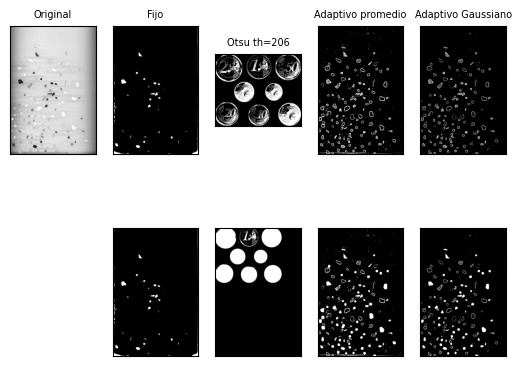

In [9]:
#Carga imagen directamente en grises
imgorig = cv2.imread('MPs.jpg', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
thotsu,imth2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)
imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i>0:
        res,imth = cv2.threshold(images[i],120,255,cv2.THRESH_BINARY)
        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)  
        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
        plt.subplot(2,5,i+6),plt.imshow(img_cont,'gray')
        plt.xticks([]),plt.yticks([])
plt.show()

Clasificación de microplásticos

Text(0.5, 1.0, 'Alquitrán')

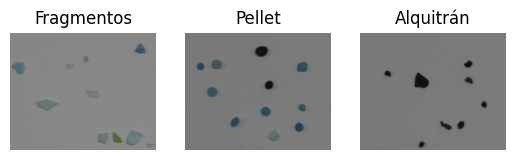

In [10]:
#Cargamos tres subimágenes de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas desde características geométricas y/o de apariencia, para distinguir en las imágenes completas, las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

Anotaciones  [3, 1, 3, 2, 2, 0, 0, 3, 2, 2, 2, 2, 0, 1, 2, 0, 0, 3, 2, 3, 2, 3, 0, 0, 3, 3, 0, 3, 1, 2, 0, 1, 0, 3, 2, 0, 0, 2, 1, 0, 2, 3, 1, 0, 1, 2, 1, 1, 3, 0, 1, 1, 3, 3, 0, 3, 1, 2, 0, 1, 3, 3, 0, 1, 3, 0, 0, 2, 2, 1, 0, 2, 0, 2, 3, 2, 0, 1, 3, 0, 1, 0, 0, 0, 1, 1, 1, 3, 0, 3, 2, 2, 0, 3, 3, 3, 2, 0, 0, 3]
Predicciones  [1, 0, 3, 2, 1, 0, 1, 0, 1, 2, 1, 2, 3, 2, 1, 2, 1, 3, 3, 1, 3, 2, 3, 2, 3, 1, 3, 1, 2, 2, 2, 3, 2, 0, 1, 3, 1, 2, 2, 3, 3, 2, 3, 3, 2, 2, 0, 2, 3, 3, 2, 1, 2, 0, 3, 2, 2, 0, 2, 2, 3, 0, 2, 0, 2, 2, 2, 1, 0, 2, 0, 3, 1, 3, 1, 0, 3, 0, 3, 0, 3, 3, 3, 2, 1, 0, 3, 3, 2, 1, 0, 1, 3, 1, 1, 2, 2, 0, 0, 1]
¿Cómo de bien encajan anotación y predicción?
Accuracy (TP/(n))= 0.21
Precision (TP/(TP+FP)) = 0.21960542929292928
Recall (TP/(TP+FN)) = 0.21
F1 Score (2*(precision*recall)/(precision+recall)) = 0.20826578712292998


Text(38.25, 0.5, 'Real/Anotado')

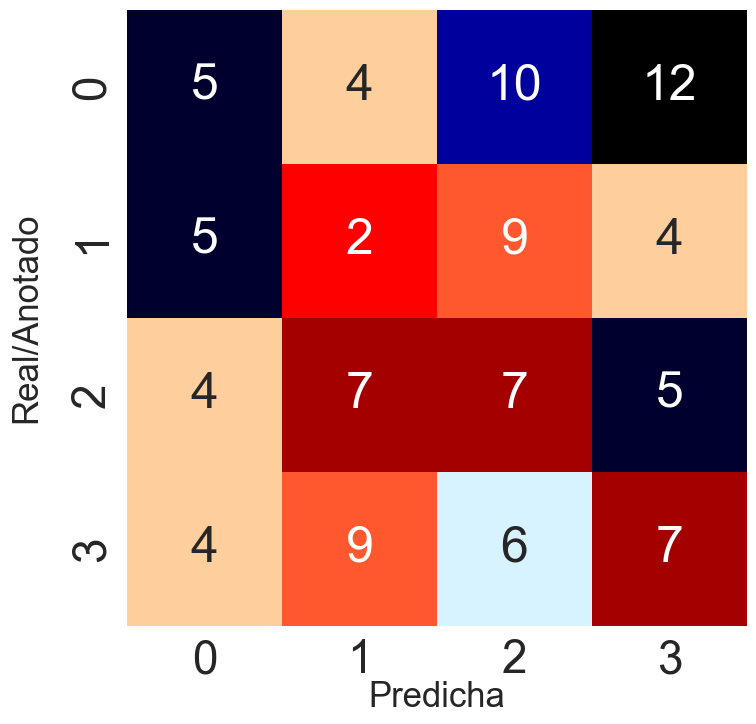

In [11]:

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

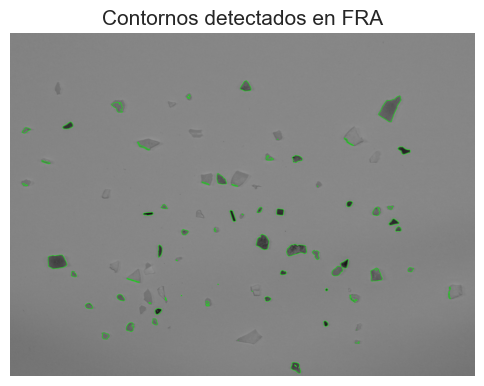

73
Número de fragmentos de plástico encontrados: (37, 3, 22)


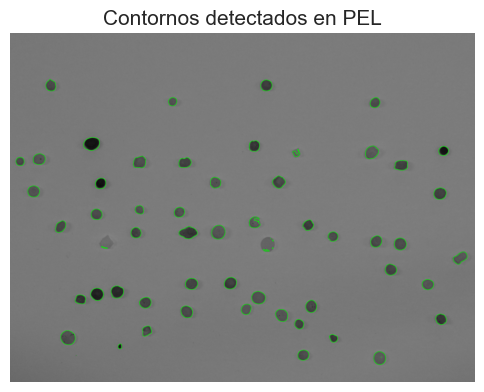

61
Número de pellets encontrados: (6, 23, 11)


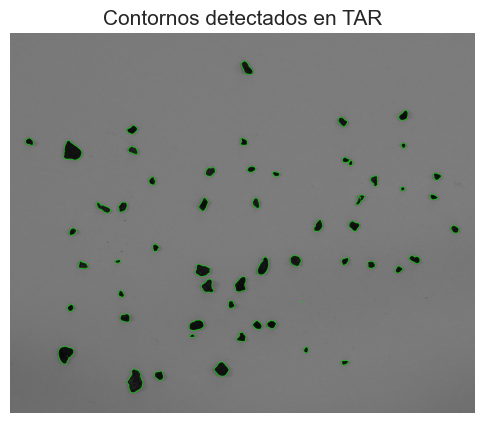

57
Número de partículas de alquitrán encontradas: (9, 3, 39)


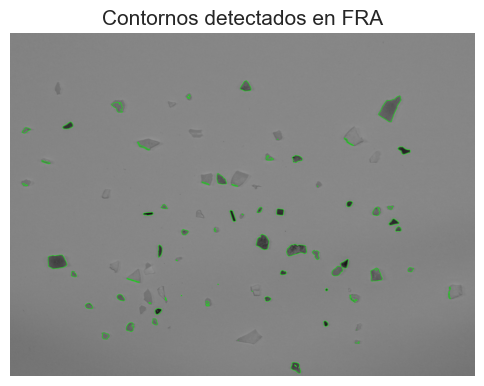

73


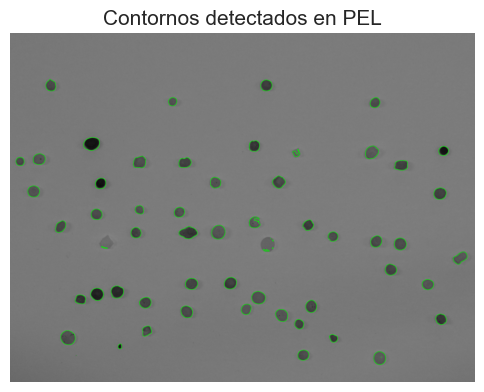

61


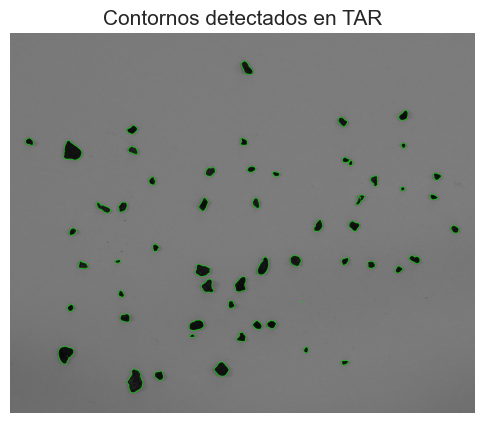

57


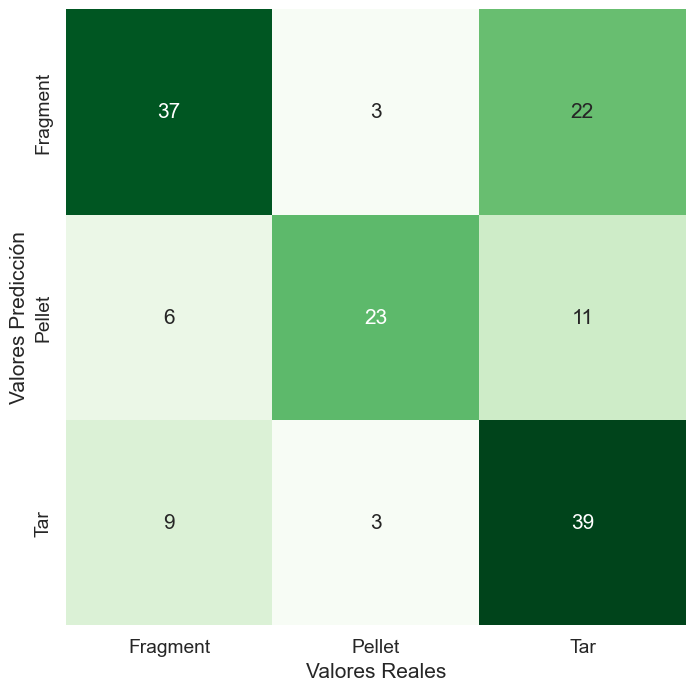

In [109]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Función para contar partículas en base a características geométricas y mostrar los contornos
def contar_particulas(imagen, img_name):
    if imagen is None:
        print(f"Error: No se pudo cargar la imagen {img_name}")
        return 0, 0, 0  # Retorna 0 en caso de que no se pueda cargar la imagen
    
    # Aplicar diferentes umbrales y suavizados según el tipo de imagen
    if img_name == 'PEL':
        blurred_image = cv2.GaussianBlur(imagen, (9, 9), 0)
        _, thresh = cv2.threshold(blurred_image, 101, 255, cv2.THRESH_BINARY_INV+ cv2.THRESH_OTSU)
    elif img_name == 'TAR':
        blurred_image = cv2.GaussianBlur(imagen, (3, 3), 0)
        _, thresh = cv2.threshold(blurred_image, 95, 255, cv2.THRESH_BINARY_INV+ cv2.THRESH_OTSU)
    elif img_name == 'FRA':
        blurred_image = cv2.GaussianBlur(imagen, (23, 23), 0)
        _, thresh = cv2.threshold(blurred_image, 100, 255, cv2.THRESH_BINARY_INV+ cv2.THRESH_OTSU)
    
    # Detección de contornos
    contornos, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Dibujar los contornos en la imagen original
    imagen_con_contornos = cv2.cvtColor(imagen, cv2.COLOR_GRAY2BGR)  # Convertir a color para dibujar
    cv2.drawContours(imagen_con_contornos, contornos, -1, (0, 255, 0), 2)

    # Mostrar los contornos detectados
    plt.figure(figsize=(6, 6))
    plt.title(f"Contornos detectados en {img_name}")
    plt.imshow(cv2.cvtColor(imagen_con_contornos, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Inicialización de contadores de partículas
    fragmentos, pellets, alquitran = 0, 0, 0
    print(len(contornos))
    # Recorremos cada contorno y calculamos las características geométricas
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)

        # Ignorar partículas demasiado pequeñas o grandes (ajustar según el dataset)
        if area < 10 or area > 5000:
            continue
        
        # Circularidad: 4 * pi * area / perimetro^2
        circularidad = (4 * np.pi * area) / (perimetro ** 2) if perimetro != 0 else 0
        
        # Relación de área con el contenedor
        x, y, w, h = cv2.boundingRect(contorno)
        relacion_alto_ancho = h / w if w != 0 else 0
        relacion_area_contenedor = area / (w * h) if w * h != 0 else 0

        # Compacidad: (perímetro^2) / área
        compacidad = (perimetro ** 2) / area if area != 0 else 0

        # Clasificación ajustada basada en características geométricas
        # Para los pellets (circular y compacta, relación de aspecto cercana a 1)
        if (0.85 <= circularidad <= 0.95) and (0.9 <= relacion_alto_ancho <= 1.1) and compacidad < 20:
            pellets += 1
        # Para los fragmentos (formas irregulares con baja relación área/contenedor y baja circularidad)
        elif (relacion_area_contenedor <= 0.65 and circularidad < 0.8):
            fragmentos += 1
        # Alquitrán (formas menos definidas con compacidad alta)
        else:
            alquitran += 1

    return fragmentos, pellets, alquitran

# Cargar imágenes
pel_image = cv2.imread('PEL1.jpg', cv2.IMREAD_GRAYSCALE)
tar_image = cv2.imread('TAR1.jpg', cv2.IMREAD_GRAYSCALE)
fra_image = cv2.imread('FRA!.jpg', cv2.IMREAD_GRAYSCALE)

# Contar partículas y mostrar los resultados
print(f"Número de fragmentos de plástico encontrados: {contar_particulas(fra_image, 'FRA')}")
print(f"Número de pellets encontrados: {contar_particulas(pel_image, 'PEL')}")
print(f"Número de partículas de alquitrán encontradas: {contar_particulas(tar_image, 'TAR')}")

# Crear la matriz de confusión con los datos obtenidos
matriz_confusion = np.array([
    contar_particulas(fra_image, 'FRA'),
    contar_particulas(pel_image, 'PEL'),
    contar_particulas(tar_image, 'TAR')
])

# Mostrar matriz de confusión
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cbar=False, cmap='Greens',
            xticklabels=['Fragment', 'Pellet', 'Tar'],
            yticklabels=['Fragment', 'Pellet', 'Tar'])
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predicción")
plt.show()






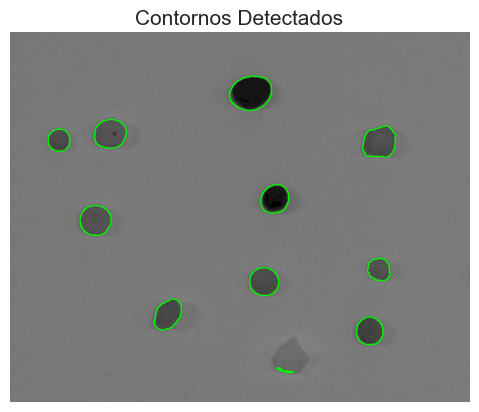

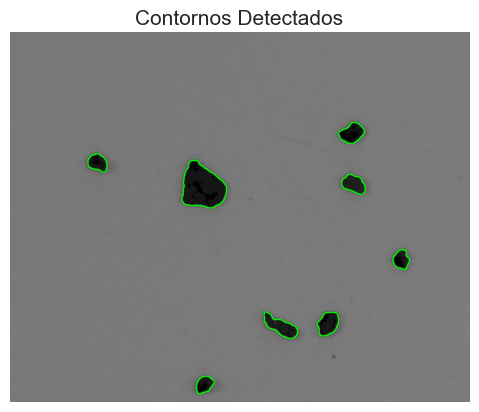

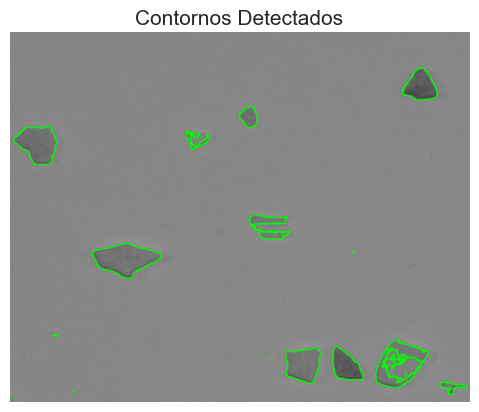

PEL: 10 partículas
TAR: 8 partículas
FRA: 13 partículas
Accuracy = 0.6
Precision = 0.5900000000000001
Recall = 0.6
F1 Score = 0.5866666666666667


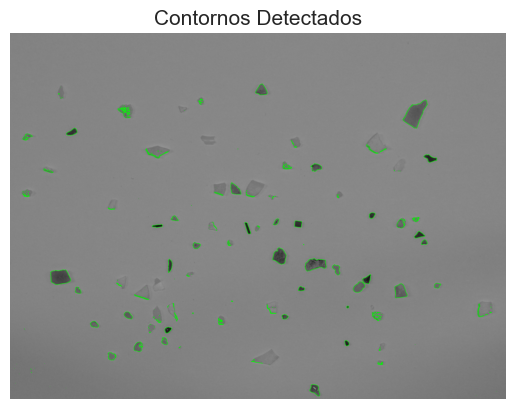

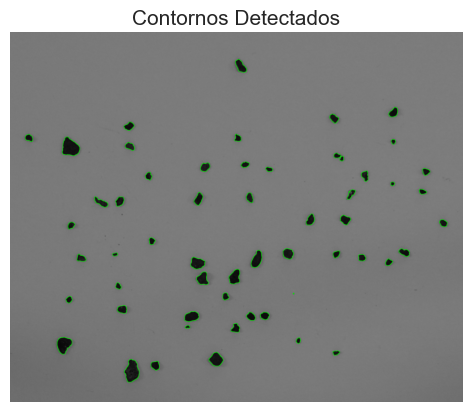

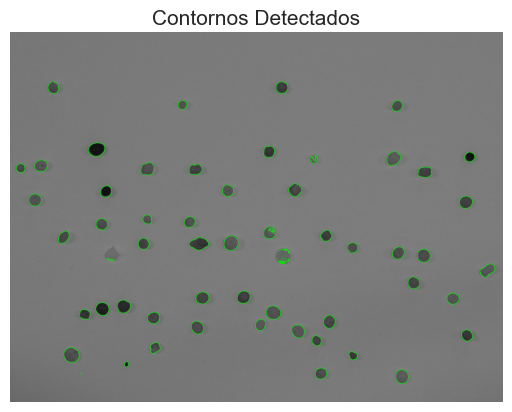

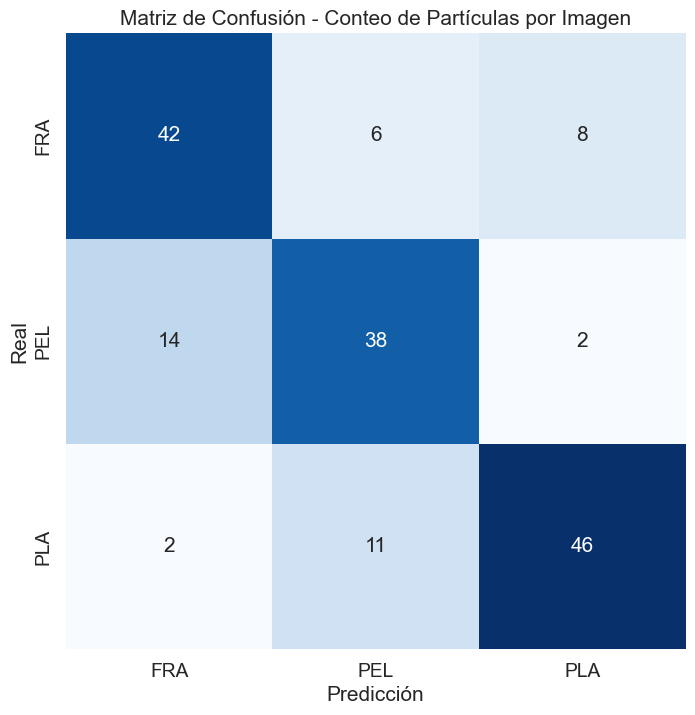

In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.preprocessing import StandardScaler

# Procesar imágenes y extraer características
def process_image(image_path, area_min=100):
    """Procesa la imagen y devuelve las características de las partículas detectadas."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"No se pudo cargar la imagen: {image_path}")

    # Binarización usando Otsu para una separación más precisa
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Encontrar contornos externos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    for cnt in contours:
        area = cv2.contourArea(cnt)

        # Filtrar contornos muy pequeños (por ruido o fragmentos)
        if area < area_min:
            continue

        perimeter = cv2.arcLength(cnt, True)
        compacity = (perimeter ** 2) / area  # Compacidad
        x, y, w, h = cv2.boundingRect(cnt)
        width_height_ratio = w / h if h != 0 else 0

        # Ajustar elipse si hay suficientes puntos en el contorno
        if len(cnt) >= 5:
            ellipse = cv2.fitEllipse(cnt)
            (center, axes, angle) = ellipse
            major_axis = max(axes)
            minor_axis = min(axes)
            ellipse_ratio = minor_axis / major_axis if major_axis != 0 else 0
        else:
            ellipse_ratio = 0

        # Calcular centroide y distancias al contorno
        moments = cv2.moments(cnt)
        if moments["m00"] != 0:
            cx = int(moments["m10"] / moments["m00"])
            cy = int(moments["m01"] / moments["m00"])
        else:
            cx, cy = 0, 0

        distances = [cv2.pointPolygonTest(cnt, (cx, cy), True) for point in cnt]
        if distances:
            max_distance = max(distances)
            min_distance = min(distances)
            distance_ratio = min_distance / max_distance if max_distance != 0 else 0
        else:
            distance_ratio = 0

        # Añadir las características a la lista
        features.append([
            area, perimeter, compacity, width_height_ratio,
            ellipse_ratio, distance_ratio
        ])

    # Mostrar los contornos detectados para depuración
    show_contours(image, contours)

    return features

def show_contours(image, contours):
    """Muestra la imagen con los contornos detectados."""
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(output, contours, -1, (0, 255, 0), 2)
    plt.imshow(output)
    plt.title("Contornos Detectados")
    plt.axis('off')
    plt.show()

# Procesar las imágenes
pel_features = process_image('PEL.png')
tar_features = process_image('TAR.png')
fra_features = process_image('FRA.png')

print(f"PEL: {len(pel_features)} partículas")
print(f"TAR: {len(tar_features)} partículas")
print(f"FRA: {len(fra_features)} partículas")

# Etiquetas
pel_labels = [0] * len(pel_features)  # Pellets
tar_labels = [1] * len(tar_features)  # Plásticos/alquitrán
fra_labels = [2] * len(fra_features)  # Fragmentos

# Crear matrices de características y etiquetas
X = np.array(pel_features + tar_features + fra_features)
y = np.array(pel_labels + tar_labels + fra_labels)

# Normalización
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar clasificador
clf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Predicción y métricas
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1score = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")



Frai_features = process_image('FRA!.JPG')  # Fragmentos
Peli_features = process_image('TAR1.JPG')   # Pellets
Plai_features = process_image('PEL1.JPG')   # Alquitrán

# Concatenar características de las nuevas imágenes
X_new = np.array(Frai_features)
X_new2 = np.array(Peli_features)
X_new3 = np.array(Plai_features)

# Normalizar las nuevas características usando el mismo escalador
X_new = scaler.transform(X_new)
X_new2 = scaler.transform(X_new2)
X_new3 = scaler.transform(X_new3)

# Predecir las clases de las nuevas imágenes
y_new_pred = clf.predict(X_new)
y_new_pred2 = clf.predict(X_new2)
y_new_pred3 = clf.predict(X_new3)

# Contar el número de partículas de cada tipo en cada imagen
# Inicializar los contadores para cada imagen
counts = {
    'FRA': [0, 0, 0],  # Fragmentos
    'PEL': [0, 0, 0],  # Pellets
    'PLA': [0, 0, 0],  # Alquitrán
}

# Contar las partículas para cada imagen
for i in y_new_pred:
    if i == 0:  # Alquitrán
        counts['PLA'][0] += 1
    elif i == 1:  # Pellets
        counts['PEL'][0] += 1
    elif i == 2:  # Fragmentos
        counts['FRA'][0] += 1

for i in y_new_pred2:
    if i == 0:  # Alquitrán
        counts['PLA'][1] += 1
    elif i == 1:  # Pellets
        counts['PEL'][1] += 1
    elif i == 2:  # Fragmentos
        counts['FRA'][1] += 1

for i in y_new_pred3:
    if i == 0:  # Alquitrán
        counts['PLA'][2] += 1
    elif i == 1:  # Pellets
        counts['PEL'][2] += 1
    elif i == 2:  # Fragmentos
        counts['FRA'][2] += 1

# Crear matriz de confusión
matriz_confusion = np.array([
    counts['FRA'],
    counts['PEL'],
    counts['PLA'],
])

# Graficar matriz de confusión con etiquetas 'FRA', 'PEL', 'PLA'
plt.figure(figsize=(8, 8))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['FRA', 'PEL', 'PLA'],
            yticklabels=['FRA', 'PEL', 'PLA'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Conteo de Partículas por Imagen")
plt.show()






